In [1]:
import numpy as np
import pandas as pd
import math

from gurobipy import GRB
from utils import file_reader as fr
from utils import data_generator as dg
from utils import problem_model as pm


# Model comparison

The question we'll try to answer in this notebook is how increasing the number of agents traversing the network (i.e., network congestion) affects the optimal solutions to the different MSPP-PD variants.  
As a first idea we can imagine that an higher number of agents that has to be routed in a network will increase the number of penalties incurred due to the higher risk of conflicts between agents' path, but later on we'll understand more deeply which are the roles of network congestion and model variant on this process.


## Read data

To carry on our analysis we'll test different MSPP-PD penalty metric variants for different levels of network congestion with several network instances.  
Each instance has the same size $(m,n) = (6,6)$, but dissimilar arc lenghts. These instances are the same as those reported in section 3.3 of the paper and have the same topology as those of the MSPP-PD(ABP) and MSPP-PD(NQP) notebooks


In [2]:
networks_df = fr.read_networks_csv("data/d_it_ij_6x6_1000it.csv",
                                   along="rows")

# show some network instances
networks_df.head()


0                   1                             2             \
           6         7         6         7         8         7         8    
it1  1.612014  1.454776  0.376347  1.263488  1.675461  0.383242  1.325470   
it2  0.345666  1.997958  1.022579  1.344409  0.335500  0.768256  0.724642   
it3  1.059043  1.866680  1.672658  0.410748  1.204280  1.351971  1.502285   
it4  0.297746  1.873162  1.144040  1.749892  0.975469  0.168817  0.553882   
it5  1.296527  1.255480  1.777435  1.812928  1.990680  0.990032  0.467010   

                     3             ...        26                  27  \
           9         8         9   ...        32        33        32   
it1  1.502733  0.959483  1.690435  ...  0.199034  1.911133  1.343548   
it2  1.146472  0.726154  0.654525  ...  0.126858  0.794601  1.432874   
it3  0.093011  0.149816  0.665625  ...  1.773551  0.360475  0.016188   
it4  1.758605  1.824679  0.606143  ...  1.398726  1.794652  0.178435   
it5  0.629513  0.962954  0.695574  ...  0.499949  0.563903  0.976726   

                               28                            29            
           33        34        33        34        35        34        35  
it1  0.238743  1.667782  1.273160  0.289610  1.523664  1.968861  1.483620  
it2  0.123810  1.866517  1.411055  1.125656  1.531357  0.725753  0.617501  
it3  1.866432  1.783597  1.205805  0.093973  1.818958  1.471756  1.272506  
it4  0.930916  0.497418  1.837166  1.315127  0.259269  1.973621  1.269510  
it5  1.407947  0.320083  0.168943  0.432240  0.193984  1.377742  0.847393  

[5 rows x 80 columns]

## Manage data

Here is where we define variables that we will use in our analysis


Since to analyze 1000 instances takes too long on our machine, we'll run the analysis on a subset of network instances


In [3]:
num_istances = 150
networks_df = networks_df.head(num_istances)

# nodes of the network instances
nodes = dg.get_nodes(networks_df)


Define the different MSPP-PD variants and the different level of network congestions to test.  
For the analysis is important the number of agents relative to the number of rows. In our cases we deal with 3, 6, 9 and 12 agents.  
Let's define the congestion level of a network as the number of agents that has to be routed divided by the number of rows of the network itself.  
This means, for our $m=6$ networks, having congestion levels of 0.5, 1, 1.5 and 2, each of which defines a different testing scenario


In [4]:
problem_types = ["MSPP", "ABP", "NBP", "ALP", "NLP", "AQP", "NQP"]
idx_of_pb_type = dict(zip(problem_types, range(len(problem_types))))

# level of network congestion <--> scenario (=number of agents that has to be routed)
scenarios = [3, 6, 9, 12]
idx_of_scenario = dict(zip(scenarios, range(len(scenarios))))


Agents' sources and termini are defined as explained in section 3.3 of the paper


In [5]:
agents_sources = [0, 1, 2, 3, 4, 5, 0, 2, 4, 1, 3, 5]
source_of_agent = dict(zip(range(0, len(agents_sources)), agents_sources))

agents_terminus = [node + 30 for node in agents_sources]
terminus_of_agent = dict(zip(range(0, len(agents_terminus)), agents_terminus))


And finally we define the variables to store the different _problem type-scenario_ results of the single network instances


In [6]:
# stores the total distance traveled by agent for a given (instance, pb_type, scenario) combination
opt_tot_distances_shape = (num_istances, len(problem_types), len(scenarios))
opt_tot_distances = np.zeros(opt_tot_distances_shape)

# store the distance traveled by each agent for a given (instance, pb_type, scenario) combination
agents_opt_distances_shape = (  # 12 bcs we have at most 12 agents to route
    12, num_istances, len(problem_types), len(scenarios))
agents_opt_distances = np.full(agents_opt_distances_shape,
                               fill_value=np.nan)


## Solve problems

Let's define a useful function to retrieve the distance covered by a single agent


In [7]:
def evaluate_agent_distance(X, w_arcs, agent):
    """Gets the distance traveled by an agent

    Args:
        X (gb.MVar): X decision variables of a MSPP or MSPP-PD
        w_arcs (list): list of WArc that compose the network
        agent (Agent): the agent for which to compute the distance traveled

    Returns:
        float: distance covered by the agent
    """
    return sum(arc.w for arc in w_arcs if math.isclose(X.x[arc.idx, agent.idx], 1))


Solve each case (weights for the 2 objectives remain the same for each case and are fixed at $(w_d, w_p) = (1,1)$)


In [ ]:
# skip this cell if you want to use pre-computed results

# for each network istance...
for it_i, network_arcs in enumerate(dg.network_instances(networks_df)):

    print(f"Solving problems for instance {it_i}...")

    for pb_type in problem_types:  # ...and for each type of problem...
        for num_of_agents in scenarios:  # ...solve a particular scenario

            # define the agents for the scenario
            agents = [dg.Agent(source_of_agent[i], terminus_of_agent[i], index=i)
                      for i in range(num_of_agents)]

            # set-up and solve the problem
            pb, X, *_ = pm.set_problem(pb_type, nodes, network_arcs, agents)
            pb.optimize()

            if pb.status != GRB.OPTIMAL:
                print(f"AAA: A {pb_type} problem on the network {it_i=} with {num_of_agents} agents encounterd problems")

            # retrieve results in which we are interested
            opt_tot_distance, *_ = pm.evaluate_pb_objectives(pb)
            opt_tot_distances[it_i,
                              idx_of_pb_type[pb_type],
                              idx_of_scenario[num_of_agents]] = opt_tot_distance

            for agent in agents:
                agents_opt_distances[agent.idx,
                                     it_i,
                                     idx_of_pb_type[pb_type],
                                     idx_of_scenario[num_of_agents]] = evaluate_agent_distance(X, network_arcs, agent)


If desired we can store results in order to avoid waiting for computations each time we run the notebook


In [ ]:
# np.save(
#     f"results/models_opt_total_distances_{num_istances}.npy", opt_tot_distances)

# np.save(
#     f"results/agent_opt_distances_{num_istances}.npy", agents_opt_distances)


## Final statistics

In this final part we'll look at the result obtained and we'll draw some conclusions about them
  

If wanted we can load the stored results and rely on them


In [8]:
opt_tot_distances = np.load(
    f"results/models_opt_total_distances_{num_istances}.npy")

agents_opt_distances = np.load(
    f"results/agent_opt_distances_{num_istances}.npy")


To identify which model is creating longer paths to avoid path conflict penalties we can compute the mean of total distance travelled over the different instances and then compare any 2 models' solutions for a given network congestion level


In [9]:
mean_opt_tot_distance = np.mean(opt_tot_distances, axis=0)

mean_opt_tot_distance_df = pd.DataFrame(mean_opt_tot_distance,
                                        columns=scenarios,
                                        index=problem_types)
mean_opt_tot_distance_df


,3,6,9,12
MSPP,8.178532,16.521932,24.821808,33.043865
ABP,8.714703,18.077787,29.374148,38.700132
NBP,9.215473,18.411961,26.858789,34.952128
ALP,8.754724,18.138159,31.582024,45.155498
NLP,9.313441,19.479118,27.917032,35.966863
AQP,8.754724,18.138159,31.628713,45.517706
NQP,9.313441,19.580366,29.826897,41.092457


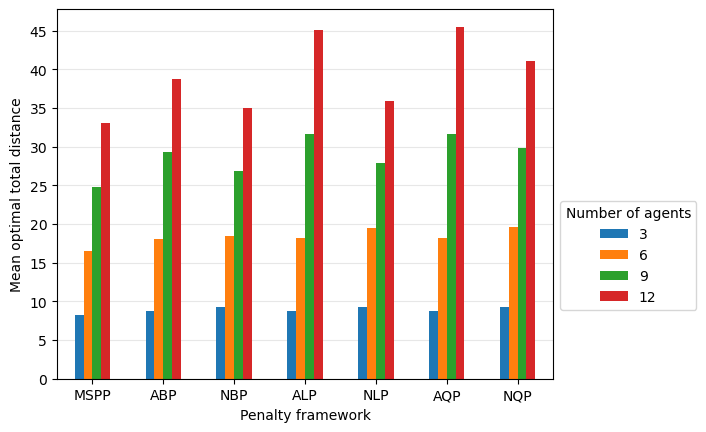

In [10]:
ax = mean_opt_tot_distance_df.plot.bar(rot=0,
                                       xlabel="Penalty framework",
                                       ylabel="Mean optimal total distance")

# add horiz. lines at step of 5 for better visualization
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 5))
ax.grid(axis="y", alpha=0.3)
ax.set_axisbelow(True)

# add legend
ax.legend(title="Number of agents",
          bbox_to_anchor=(1, 0.5))


By looking at the bar plot we can say that the relationship between the model variants over different levels of network congestion is dynamic in the sense that the degree to wich each of the models' mean optimal total distance travelled differs relative to the MSPP solution changes as congestion level changes.  
For instance the greatest mean difference in the 6-agent scenario is the MSPP(PD)-NQP, but it is MSPP-PD(AQP) for the 9-gent case.  

We can additionaly note that the incerases in difference in mean, that coincide with the increases in network congestion, indicate that certain MSPP-PD variants may not incentivize path deconfliction for highly congested networks


Indeed when conflict penalties become unavoidable, the objective of minimizing distance dominates the optimal solution for certain models as distance-minimizing paths are exploited to overcome path conflict penalties that are not weighted heavily in comparison, as can be seen on the following table.  


In [11]:
avg_agents_opt_distances = np.nanmean(agents_opt_distances, axis=(0, 1))

avg_agents_opt_distances_df = pd.DataFrame(avg_agents_opt_distances.T,
                                            columns=problem_types,
                                            index=scenarios)

print("Average agent distance travelled for each (problem type-scenario) combination:")
avg_agents_opt_distances_df.head()


Average agent distance travelled for each (problem type-scenario) combination:


,MSPP,ABP,NBP,ALP,NLP,AQP,NQP
3,2.726177,2.904901,3.071824,2.918241,3.104480,2.918241,3.104480
6,2.753655,3.009539,3.068660,3.023027,3.246520,3.023027,3.256811
9,2.757979,3.192843,2.928355,3.509114,3.101892,3.499713,3.314100
12,2.753655,3.167899,2.851470,3.762958,2.995170,3.766495,3.292988


As can be seen the MSPP-PD(ABP), MSPP-PD(NBP), MSPP-PD(NLP) and MSPP-PD(NQP) model variants' average agent path length decreases after a certain level of network congestion, thus demonstrates the last statement we made (in particular this can be seen when passing from 9 to 12 agents).  
MSPP-PD(ALP) and MSPP-PD(AQP), on the other hand, tends to deconflict agents' paths "more" than other variants for a given congestion level as can be seen from the strictly increase of the average agent distance travelled for increasing level of congestion.  
So we can conclude that if path deconfliction is more important than distances travelled and we do not want to specifically adjust the weights of the objective functions we should select ALP or AQP model variants.


---

Note: the results we've reported are slightly different from those reported in paper, but this may be due to the lower number of network instances on which we've computed the averages.
